# Kernel Kannibals - Final Report
*Setting out to find Pittsburgh's best neighborhood.*

## Introduction

Our task was to find Pittsburgh's best neighborhood.
Before we could begin, we first had to decide *what* qualities determine the best neighborhood.

We wanted to come up with a playful metric, and we struck the perfect one: **The Mob Boss Friendliness Index**

Of course, why *wouldn't* the best neighborhood be the best one for a mob boss!?

Now that we had an idea for our metric, we had to determine what qualities should factor in.
We ended up choosing three data sets:
- Number of Police Arrests (less is better)
  - Source: https://data.wprdc.org/dataset/arrest-data
- Number of Firearm Seizures (less is better)
  - Source: https://data.wprdc.org/dataset/pbp-fire-arm-seizures/
- Number of Tobacco Shops (more is better)
  - Source: https://data.wprdc.org/dataset/allegheny-county-tobacco-vendors
  - Also used: https://data.wprdc.org/dataset/property-assessments

With our metric and data sets in mind, we set out to begin analysis!

## Analyzing Our Data Sets

### Setup

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import requests

### Number of Police Arrests

Based on just the graph below, the best neighborhood for a mob boss would be Mt. Oliver.

Analysis Result:


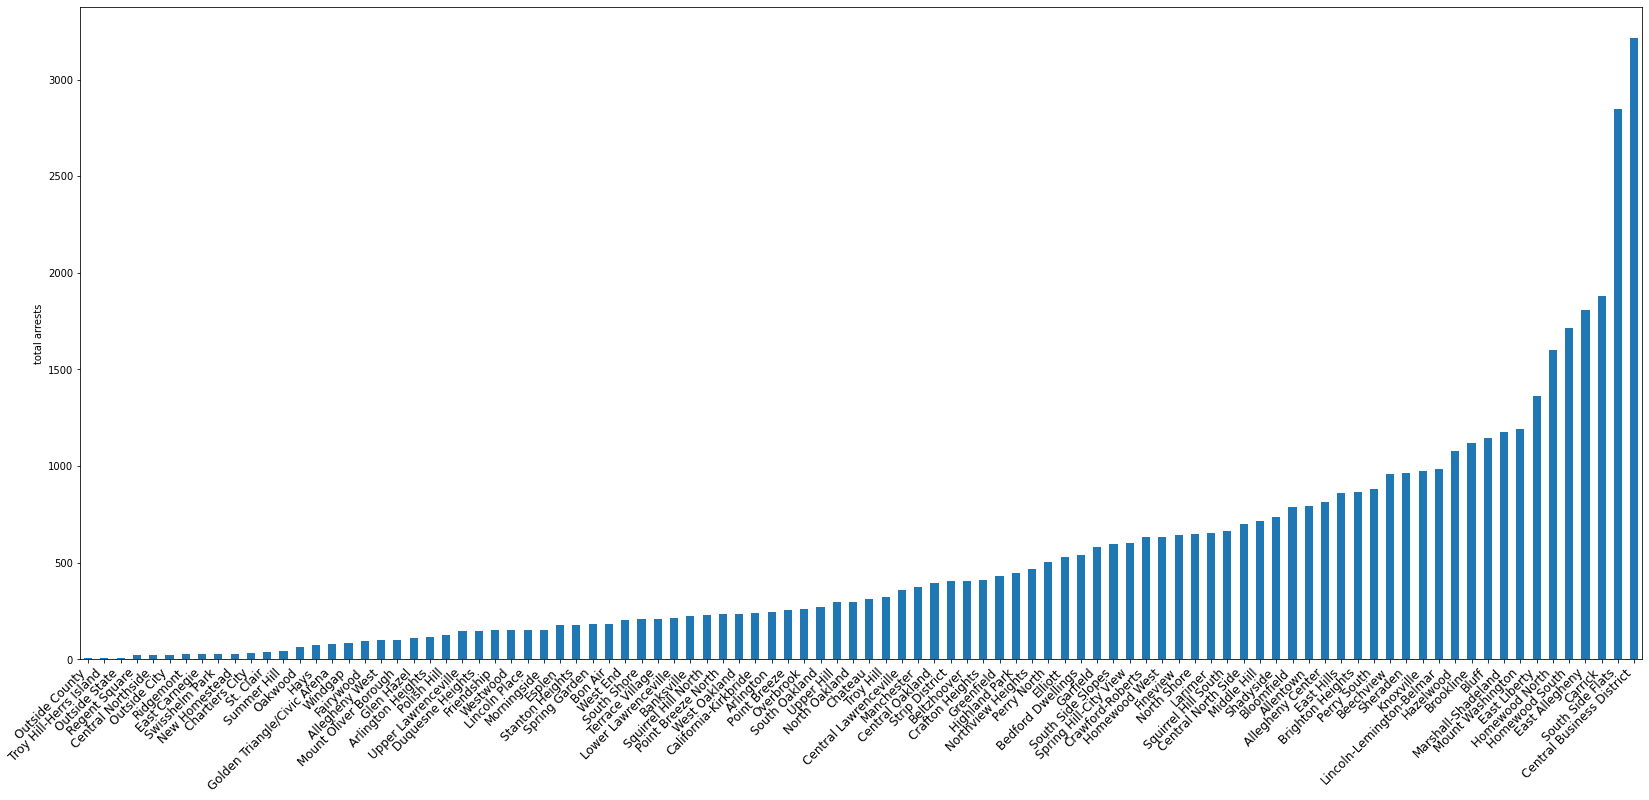

In [12]:
arrest_data = pd.read_csv("devansh/arrests.csv").dropna()

# some cleanup
arrest_data["INCIDENTNEIGHBORHOOD"] = arrest_data["INCIDENTNEIGHBORHOOD"].replace("Mt. Oliver Neighborhood", "Mount Oliver Borough")
arrest_data["INCIDENTNEIGHBORHOOD"] = arrest_data["INCIDENTNEIGHBORHOOD"].replace("Mt. Oliver Boro", "Mount Oliver Borough")
arrest_data["INCIDENTNEIGHBORHOOD"] = arrest_data["INCIDENTNEIGHBORHOOD"].replace("Mount Oliver", "Mount Oliver Borough")

arrest_data["INCIDENTNEIGHBORHOOD"].value_counts(ascending=True).plot(kind="bar", figsize=(28,12)).set_ylabel("total arrests")
plt.xticks(
    rotation = 45,
    horizontalalignment="right",
    fontweight="medium",
    fontsize="large"
)

print("Analysis Result:")

### Number of Firearm Seizures

Based on just the graph below, the best neighborhood for a mob boss would be Swisshelm Park or Summer Hill.

Analysis Result:


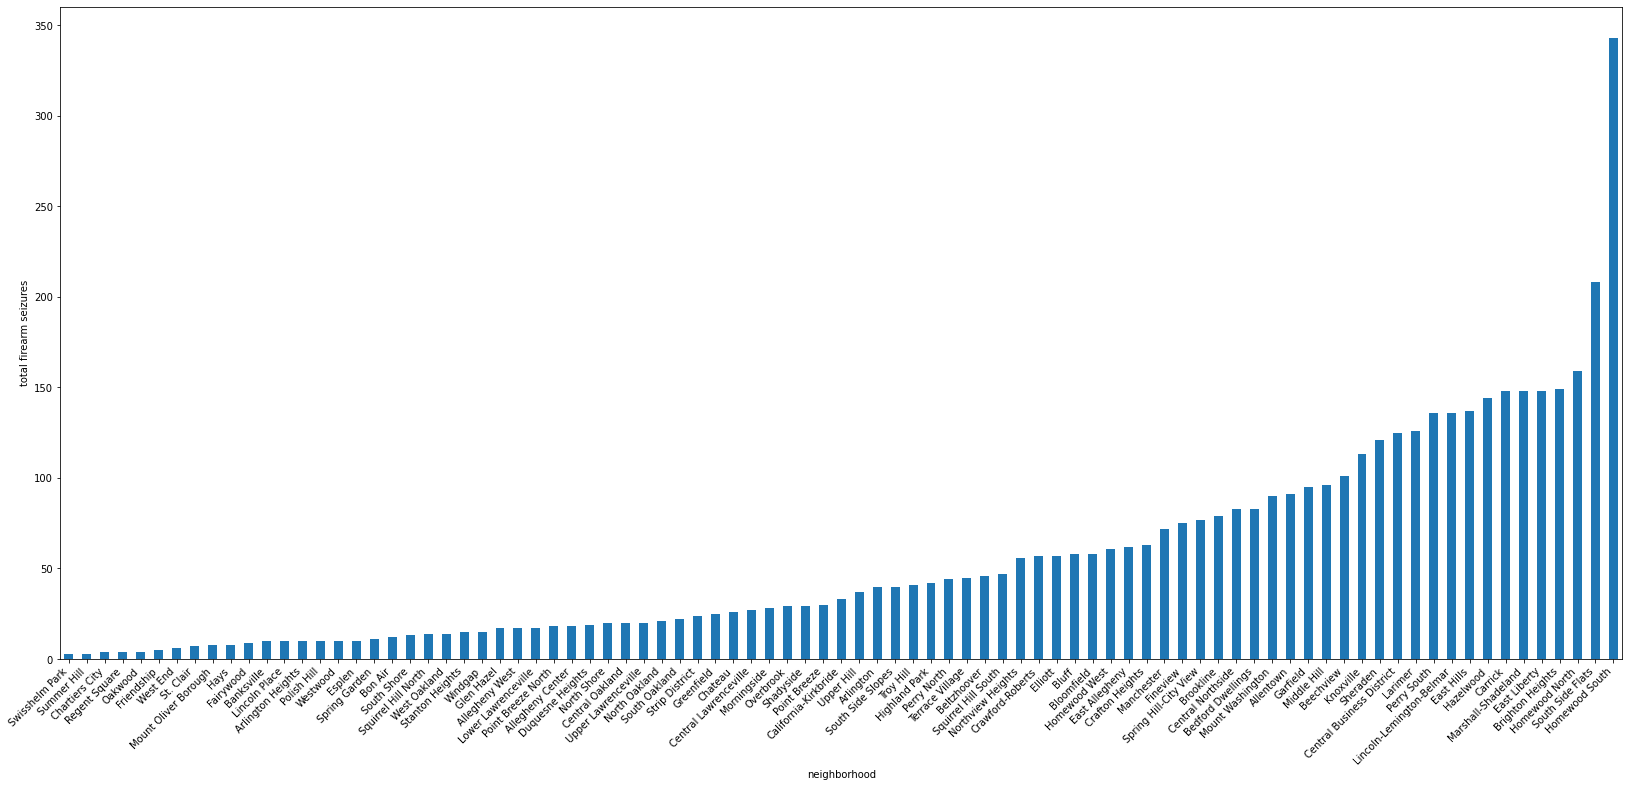

In [13]:
firearm_data = pd.read_csv("patrick/firearm_seizures.csv").dropna()

# some cleanup
firearm_data["neighborhood"] = firearm_data["neighborhood"].replace("Mt. Oliver","Mount Oliver Borough")
firearm_data["neighborhood"] = firearm_data["neighborhood"].replace("Mount Oliver","Mount Oliver Borough")

firearm_data.groupby("neighborhood").sum()["total_count"].sort_values(ascending=True).plot.bar(figsize=(28, 12)).set_ylabel("total firearm seizures")
plt.xticks(
    rotation=45,
    horizontalalignment='right',
    fontweight='medium',
    fontsize='medium',
)
print("Analysis Result:")

### Number of Tobacco Shops

Although data is lower with this data set, we can still conclude from it (based on this data alone) that South Side Flats is the best neighborhood for a mob boss.

Analysis Result:


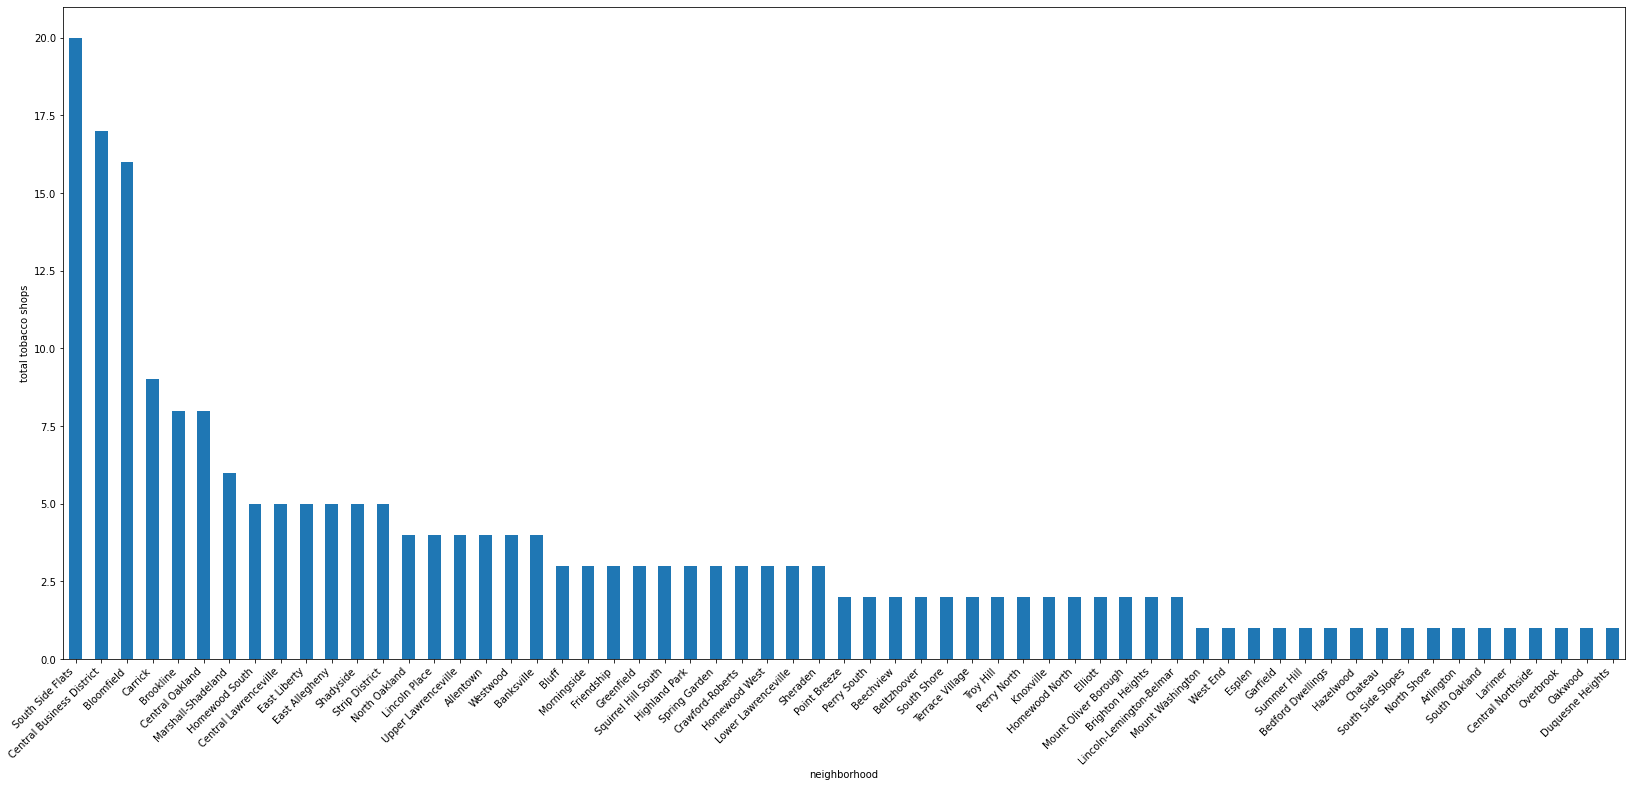

In [4]:
def clean_street(street):
    return street.replace("AVENUE", "AVE", 1).replace("STREET", "ST", 1).replace("BOULEVARD", "BLVD", 1).replace("HIGHWAY", "HWY", 1)

tobacco_data = pd.read_csv("patrick/tobacco_data.csv")
tobacco_data = tobacco_data.applymap(lambda x: x.strip() if isinstance(x, str) else x)
tobacco_data = tobacco_data[tobacco_data.apply(lambda row: True if (row.City == "PITTSBURGH") or (row.City == "PGH") else False,axis=1)]

parcel_mappings = { }
for index, row in pd.read_csv("patrick/clean_assessments.csv").iterrows():
    parcel_mappings[str(row['PROPERTYHOUSENUM']) + " " + row['PROPERTYADDRESS']] = row['PARID']

parcel_ids = [ ]
for index, row in tobacco_data.iterrows():
    street = row['Street1']
    street = clean_street(street)
    if street in parcel_mappings:
        parcel_ids.append(parcel_mappings[street])
    else:
        street = row['Street2']
        if street:
            street = clean_street(street)
            if street in parcel_mappings:
                parcel_ids.append(parcel_mappings[street])

request_strings = [ ]
current_request = ""
current_index = 1
for parcel_id in parcel_ids:
    current_request = current_request + parcel_id + ","
    current_index += 1
    if current_index == 10:
        current_request = current_request[:-1]
        request_strings.append(current_request)
        current_request = ""
        current_index = 1

neighborhood_counts = { }
for request_string in request_strings:
    result = requests.get(url = "https://tools.wprdc.org/property-api/v0/parcels/" + request_string)
    json = result.json()
    for result in json["results"]:
        try:
            neighborhood = result["data"]["centroids_and_geo_info"][0]["geo_name_nhood"]
        except:
            continue
        if neighborhood == None:
            continue
        if neighborhood in neighborhood_counts:
            neighborhood_counts[neighborhood] += 1
        else:
            neighborhood_counts[neighborhood] = 1

tobacco_data = pd.DataFrame(neighborhood_counts.items(), columns=["neighborhood", "num_tobacco_shops"])
tobacco_data.groupby("neighborhood").sum()["num_tobacco_shops"].sort_values(ascending=False).plot.bar(figsize=(28, 12)).set_ylabel("total tobacco shops")
plt.xticks(
    rotation=45,
    horizontalalignment='right',
    fontweight='medium',
    fontsize='medium',
)
print("Analysis Result:")

## The Best Neighborhood

We have some statistics from our data sets, but they don't yet tell the full story. In fact, they somewhat disagree with each other.

The solution? Combine these stats together to calculate a score for each neighborhood.

It should be noted that we are not factoring in population density here.
However, we decided that this would be okay, asserting that the lower numbers can imply a quieter or less-policed neighborhood.

Due to less data for the Tobacco Shops, it will be less heavily weighed.

The weights are as follows:
- Arrests: 40%
- Firearm Seziures: 40%
- Tobacco Shops: 20%

In [36]:
neighborhood_scores = { }

def prepare_neighborhoods(neighborhoods):
    for neighborhood in neighborhoods:
        if not neighborhood in neighborhood_scores:
            neighborhood_scores[neighborhood] = 0

prepare_neighborhoods(arrest_data["INCIDENTNEIGHBORHOOD"].unique())
prepare_neighborhoods(firearm_data["neighborhood"].unique())
prepare_neighborhoods(tobacco_data["neighborhood"].unique())

# get max + mins
arrests_min = arrest_data["INCIDENTNEIGHBORHOOD"].value_counts().min()
arrests_max = arrest_data["INCIDENTNEIGHBORHOOD"].value_counts().max()

firearms_min = firearm_data.groupby("neighborhood").sum()["total_count"].min()
firearms_max = firearm_data.groupby("neighborhood").sum()["total_count"].max()

tobacco_min = tobacco_data.groupby("neighborhood").sum()["num_tobacco_shops"].min()
tobacco_max = tobacco_data.groupby("neighborhood").sum()["num_tobacco_shops"].max()

for neighborhood in neighborhood_scores.keys():
    # get value for neighborhoods
    num_arrests = len(arrest_data[arrest_data['INCIDENTNEIGHBORHOOD'] == neighborhood])
    num_firearm_seizures = firearm_data[firearm_data['neighborhood'] == neighborhood].sum()["total_count"].max()
    num_tobacco_shops = tobacco_data[tobacco_data['neighborhood'] == neighborhood].sum()["num_tobacco_shops"].max()
    
    # calculate "grade" in category
    num_arrests = 100 - (((num_arrests - arrests_min) / (arrests_max - arrests_min)) * 100.0)
    if num_arrests < 0:
        num_arrests = 0
    num_firearm_seizures = 100 - (((num_firearm_seizures - firearms_min) / (firearms_max - firearms_min)) * 100.0)
    if num_firearm_seizures < 0:
        num_firearm_seizures = 0
    num_tobacco_shops = ((num_tobacco_shops - tobacco_min) / (tobacco_max - tobacco_min)) * 100.0
    if num_tobacco_shops < 0:
        num_tobacco_shops = 0

    # calculate and store weighted score
    neighborhood_scores[neighborhood] = (num_arrests * 0.40) + (num_firearm_seizures * 0.40) + (num_tobacco_shops * 0.20)

Now that we have scores prepared, we can plot them:

Final Result:


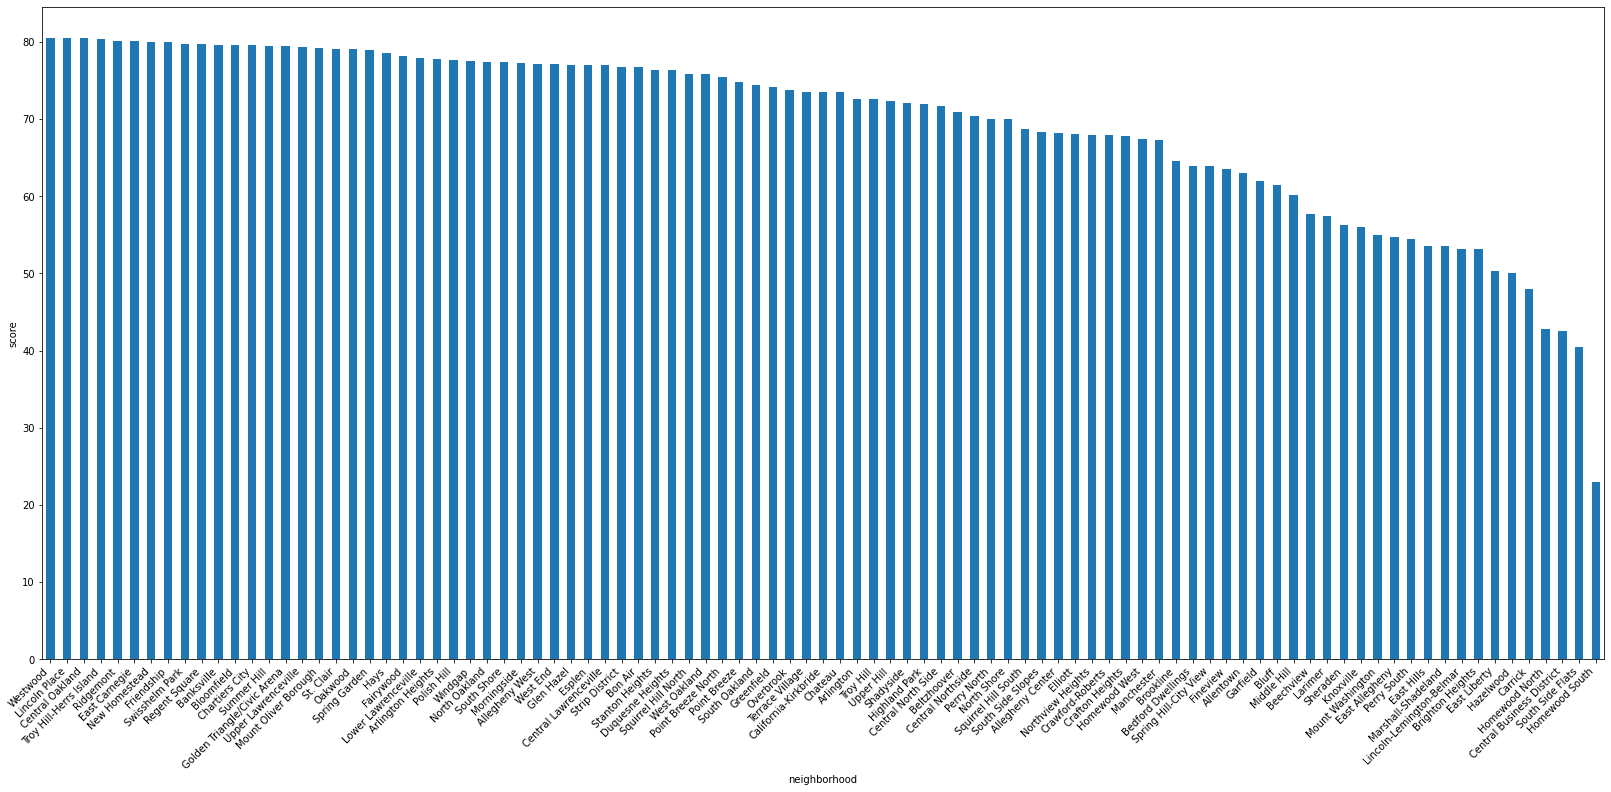

In [37]:
score_data = pd.DataFrame(neighborhood_scores.items(), columns=["neighborhood", "score"])

# hmm, some weird results have made it in!
# filter them out
score_data = score_data[score_data.neighborhood != "Outside City"]
score_data = score_data[score_data.neighborhood != "Outside County"]
score_data = score_data[score_data.neighborhood != "Outside State"]

score_data.groupby("neighborhood").sum()["score"].sort_values(ascending=False).plot.bar(figsize=(28, 12)).set_ylabel("score")
plt.xticks(
    rotation=45,
    horizontalalignment='right',
    fontweight='medium',
    fontsize='medium',
)
print("Final Result:")

## And the winner is...

Wait a minute! Those values are *really* close! We're going to need to take a closer look...

In [33]:
score_data[score_data.score > 80].sort_values(by="score",ascending=False).head()

,neighborhood,score
1,Westwood,80.515617
48,Lincoln Place,80.490703
18,Central Oakland,80.472750
23,Troy Hill-Herrs Island,80.340484
11,East Carnegie,80.091340


## And the winner *really* is...

# ✨WESTWOOD✨

With a score advantage of about **0.02**, Westwood has topped the chart!

It is Pittsburgh's *best* neighborhood!

Also, just to warn the mob bosses out there, **don't** go to Homewood South!

## Conclusion

### Patrick

Of course, any neighborhood that is a friend of mob bosses is a friend of mine. To be honest, I learned from this project that I don't really know *any* of Pittsburgh's neighborhoods, even though I've been living in this part of the state for my entire life. Doing some further research, I found that a lot of people to seem to like this small neighborhood. It's notable for it's safety and quietness (quietness being a particularly good quality for any interested mobs). There are definitely some new neighborhoods on my list to explore!

### Devansh